In [35]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import funcs.CCE as CCE
from funcs.likelihood_funcs import * 
from funcs.utils import *
from funcs.kernel_param_funcs import *
from funcs.qnm_selecting_funcs import *
import corner
import scipy
import pickle
import matplotlib.colors as mcolors
from matplotlib.ticker import LogFormatter

from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [36]:
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

In [46]:
id = "0001"

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
new_times = np.arange(sim_main.times[0], sim_main.times[-1], 0.5)
sim_main = sim_interpolator(sim_main, new_times)

n_max = 6

TRAINING_START_TIME = -10
TRAINING_END_TIME = 100
TIME_STEP = 0.5

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)]
spherical_modes = [(2, 2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [47]:
kernel_analysis_times = np.arange(
    TRAINING_START_TIME, TRAINING_START_TIME + TRAINING_END_TIME, TIME_STEP
)

In [ ]:
with open('tuned_params.pkl', 'rb') as f:
    tuned_params = pickle.load(f)

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    params = pickle.load(f)

with open('R_dict_sim_lm_full.pkl', 'rb') as f:
    R = pickle.load(f)

tuned_params_lm = tuned_params[id]
params_lm = params[id]
R_lm = R[id]

## Residual figure

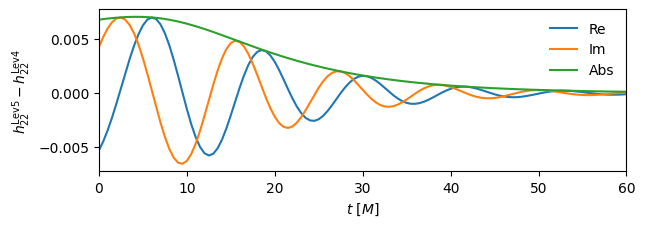

In [49]:
fig, ax = plt.subplots(figsize=(fig_width * 2, fig_height))

ax.plot(kernel_analysis_times, np.real(R_lm[2, 2]), label="Re")
ax.plot(kernel_analysis_times, np.imag(R_lm[2, 2]), label="Im")
ax.plot(kernel_analysis_times, np.abs(R_lm[2, 2]), label="Abs")

# axs[i].set_ylabel(f'$h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}$')
# axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

ax.set_xlim(0, 60)
ax.set_ylabel(r"$h_{22}^\mathrm{Lev5} - h_{22}^\mathrm{Lev4}$")
ax.set_xlabel("$t \,\, [M]$")
ax.legend(frameon=False)

## Credible region for one kernel

In [52]:
kernel_dict = {
    mode: compute_kernel_matrix(kernel_analysis_times, tuned_params_lm[mode], kernel_main)
    for mode in tuned_params_lm.keys()
}

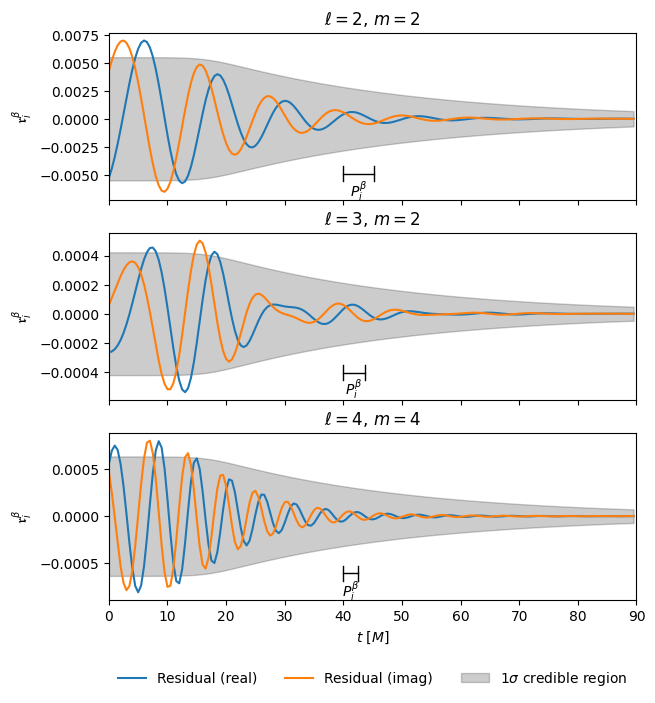

In [53]:
spherical_modes = [(2, 2), (3, 2), (4, 4)]

fig, axs = plt.subplots(
    len(spherical_modes), 1, sharex=True, figsize=(fig_width * 2, fig_height * 3.5)
)

for i, (ell, m) in enumerate(spherical_modes):

    axs[i].plot(
        kernel_analysis_times, np.real(R_lm[ell, m]), label="Residual (real)"
    )
    axs[i].plot(
        kernel_analysis_times, np.imag(R_lm[ell, m]), label="Residual (imag)"
    )

    # Plot a line segment to indicate the size of 1 x axis unit

    period_length = tuned_params_lm[(ell, m)]["period"]

    axs[i].plot(
        [40, 40 + period_length],
        [
            np.min(np.real(R_lm[ell, m])) * 0.75,
            np.min(np.real(R_lm[ell, m])) * 0.75,
        ],
        "k-",
        lw=1,
    )
    axs[i].plot(
        [40, 40],
        [
            np.min(np.real(R_lm[ell, m]))* 0.75
            - 0.05 * np.ptp(np.real(R_lm[ell, m])),
            np.min(np.real(R_lm[ell, m]))* 0.75
            + 0.05 * np.ptp(np.real(R_lm[ell, m])),
        ],
        "k-",
        lw=1,
    )
    axs[i].plot(
        [40 + period_length, 40 + period_length],
        [
            np.min(np.real(R_lm[ell, m]))* 0.75
            - 0.05 * np.ptp(np.real(R_lm[ell, m])),
            np.min(np.real(R_lm[ell, m]))* 0.75
            + 0.05 * np.ptp(np.real(R_lm[ell, m])),
        ],
        "k-",
        lw=1,
    )
    axs[i].text(
        40 + period_length / 2,
        np.min(np.real(R_lm[ell, m]))* 0.75
        - 0.15 * np.ptp(np.real(R_lm[ell, m])),
        r"$P^{\beta}_i$",
        ha="center",
    )

    # Plot the 1-sigma credible region of the GP
    axs[i].fill_between(
        kernel_analysis_times,
        -np.sqrt(np.diag(kernel_dict[ell, m])),
        np.sqrt(np.diag(kernel_dict[ell, m])),
        color="black",
        alpha=0.2,
        label=r"1$\sigma$ credible region",
    )

    axs[i].set_title(rf"$\ell = {ell},\, m = {m}$")
    axs[i].set_xlim(0, -10 + 100)
    axs[i].set_ylabel(r"$\mathfrak{r}^{\beta}_{i}$")

axs[-1].legend(frameon=False, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.6))
axs[-1].set_xlabel("$t \,\, [M]$")

fig.savefig("credible_regions.pdf", dpi=600, bbox_inches="tight")

## Credible regions for three kernels 

kernel_s = simple identity 
kernel = current best guess 
kernel_c = squared exponential + periodic 

In [54]:
hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

hyperparam_rule_dict = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

hyperparam_rule_dict_c = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
    "length_scale_2": "multiply",
    "period_2": "multiply",
    "a": "sum",
}

In [ ]:
tuning_hyperparams_s = [0.3239257812499994]

tuning_hyperparams = [
    0.7805154283170234,
    -0.005843760691585904,
    2.9693696011904516,
    0.4625481109994475,
]

tuning_hyperparams_c = [
    1.3845154849576686,
    -2.437133659687757,
    4.188168751537448,
    0.262584535730192,
    0.8633735309245427,
    4.997781528838571,
    -0.24031025069876782,
]

tuned_param_dict_s = {}
tuned_param_dict = {}
tuned_param_dict_c = {}

for mode in params[id].keys():
    tuned_param_dict_s[mode] = get_new_params(
        params[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s
    )
    tuned_param_dict[mode] = get_new_params(
        params[id][mode], tuning_hyperparams, hyperparam_rule_dict
    )
    tuned_param_dict_c[mode] = get_new_params(
        params[id][mode], tuning_hyperparams_c, hyperparam_rule_dict_c
    )

NameError: name 'param_dict_sim_lm' is not defined

In [ ]:
print(param_dict_sim_lm[id][(2, 2)])
print(tuned_param_dict_s[(2, 2)])
print(tuned_param_dict[(2, 2)])
print(tuned_param_dict_c[(2, 2)])

{'sigma_max': 0.007043225329720454, 'sigma_min': 0.0007043225329720455, 't_s': 17.0, 'sharpness': 16, 'length_scale': 11.70660990033674, 'period': 11.352296467475231, 'length_scale_2': 11.70660990033674, 'period_2': 11.352296467475231, 'a': 0.5}
{'sigma_max': 0.0028252000040846414, 'sigma_min': 2.8252000040846415e-06, 't_s': 17.0, 'sharpness': 16, 'length_scale': 11.70660990033674, 'period': 11.352296467475231, 'length_scale_2': 11.70660990033674, 'period_2': 11.352296467475231, 'a': 0.5}
{'sigma_max': 0.009591209899157965, 't_s': 15.24915979185724, 'length_scale': 49.37951529264791, 'period': 5.825444582707862, 'sigma_min': 9.591209899157964e-06, 'sharpness': 16, 'length_scale_2': 11.70660990033674, 'period_2': 11.352296467475231, 'a': 0.5}
{'sigma_max': 0.00975145453304405, 't_s': 14.562866340312244, 'length_scale': 49.02925777102926, 'period': 2.9809374973834823, 'length_scale_2': 10.10717712480994, 'period_2': 56.73629759504707, 'a': 0.2596897493012322, 'sigma_min': 9.7514545330440

In [ ]:
kernel_dict_s = {
    mode: kernel(analysis_times, **tuned_param_dict_s[mode])
    for mode in param_dict_sim_lm[id].keys()
}
kernel_dict = {
    mode: kernel(analysis_times, **tuned_param_dict[mode])
    for mode in param_dict_sim_lm[id].keys()
}
kernel_dict_c = {
    mode: kernel(analysis_times, **tuned_param_dict_c[mode])
    for mode in param_dict_sim_lm[id].keys()
}

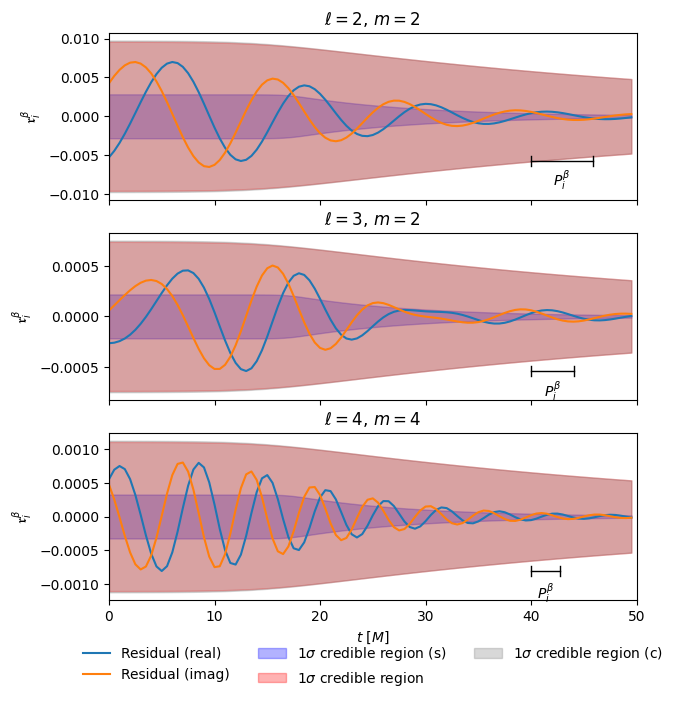

In [ ]:
spherical_modes = [(2, 2), (3, 2), (4, 4)]

fig, axs = plt.subplots(
    len(spherical_modes), 1, sharex=True, figsize=(fig_width * 2, fig_height * 3.5)
)

for i, (ell, m) in enumerate(spherical_modes):

    axs[i].plot(
        analysis_times, np.real(R[ell, m])[analysis_mask], label="Residual (real)"
    )
    axs[i].plot(
        analysis_times, np.imag(R[ell, m])[analysis_mask], label="Residual (imag)"
    )

    # Plot a line segment to indicate the size of 1 x axis unit

    period_length = tuned_param_dict[(ell, m)]["period"]

    axs[i].plot(
        [40, 40 + period_length],
        [
            np.min(np.real(R[ell, m])[analysis_mask]),
            np.min(np.real(R[ell, m])[analysis_mask]),
        ],
        "k-",
        lw=1,
    )
    axs[i].plot(
        [40, 40],
        [
            np.min(np.real(R[ell, m])[analysis_mask])
            - 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask]),
            np.min(np.real(R[ell, m])[analysis_mask])
            + 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask]),
        ],
        "k-",
        lw=1,
    )
    axs[i].plot(
        [40 + period_length, 40 + period_length],
        [
            np.min(np.real(R[ell, m])[analysis_mask])
            - 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask]),
            np.min(np.real(R[ell, m])[analysis_mask])
            + 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask]),
        ],
        "k-",
        lw=1,
    )
    axs[i].text(
        40 + period_length / 2,
        np.min(np.real(R[ell, m])[analysis_mask])
        - 0.25 * np.ptp(np.real(R[ell, m])[analysis_mask]),
        r"$P^{\beta}_i$",
        ha="center",
    )

    # Plot the 1-sigma credible region of the GP
    axs[i].fill_between(
        analysis_times,
        -np.sqrt(np.diag(kernel_dict_s[ell, m])),
        np.sqrt(np.diag(kernel_dict_s[ell, m])),
        color="blue",
        alpha=0.3,
        label=r"1$\sigma$ credible region (s)",
    )

    axs[i].fill_between(
        analysis_times,
        -np.sqrt(np.diag(kernel_dict[ell, m])),
        np.sqrt(np.diag(kernel_dict[ell, m])),
        color="red",
        alpha=0.3,
        label=r"1$\sigma$ credible region",
    )

    axs[i].fill_between(
        analysis_times,
        -np.sqrt(np.diag(kernel_dict_c[ell, m])),
        np.sqrt(np.diag(kernel_dict_c[ell, m])),
        color="grey",
        alpha=0.3,
        label=r"1$\sigma$ credible region (c)",
    )

    axs[i].set_title(rf"$\ell = {ell},\, m = {m}$")
    axs[i].set_xlim(t0, t0 + T)
    axs[i].set_ylabel(r"$\mathfrak{r}^{\beta}_{i}$")

axs[-1].legend(frameon=False, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.6))
axs[-1].set_xlabel("$t \,\, [M]$")

fig.savefig("credible_regions.pdf", dpi=600, bbox_inches="tight")

## Softclip demo

In [ ]:
def logoneplusexp(x):
    ans = np.log(1 + np.exp(-np.abs(x))) + np.maximum(x, 0)
    return ans


def smoothclip(x, x_min, x_max, sharpness):
    clipped_x = (
        x
        - (1.0 / sharpness) * logoneplusexp(sharpness * (x - x_max))
        + (1.0 / sharpness) * logoneplusexp(-sharpness * (x - x_min))
    )
    return clipped_x


def softclip(x, x_min, x_max, sharpness):
    return np.exp(smoothclip(np.log(x), np.log(x_min), np.log(x_max), sharpness))

/tmp/ipykernel_479753/633731441.py:12: RuntimeWarning: divide by zero encountered in log
  return np.exp(smoothclip(np.log(x), np.log(x_min), np.log(x_max), sharpness))
/tmp/ipykernel_479753/633731441.py:12: RuntimeWarning: invalid value encountered in log
  return np.exp(smoothclip(np.log(x), np.log(x_min), np.log(x_max), sharpness))
/tmp/ipykernel_479753/633731441.py:6: RuntimeWarning: invalid value encountered in add
  clipped_x = x - \


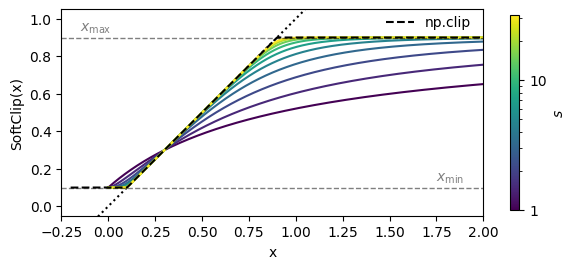

In [ ]:
# Example data
x = np.linspace(-0.2, 2, 10000)
sharpnesses = np.logspace(0, 1.5, 10)
# sharpnesses = np.linspace(0, 16, 16)
x_min, x_max = 0.1, 0.9

colors = plt.cm.viridis(np.linspace(0, 1, len(sharpnesses)))

fig, ax = plt.subplots(figsize=(fig_width * 2, fig_height * 1.5))

ax.plot(x, x, ls=":", c="k")
for i, sharpness in enumerate(sharpnesses):
    ax.plot(x, softclip(x, x_min, x_max, sharpness), color=colors[i])

ax.plot(x, np.clip(x, x_min, x_max), c="k", label="np.clip", ls="--")
ax.set_xlabel("x")
ax.set_ylabel(r"SoftClip(x)")
ax.set_xlim(-0.25, 2)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect("equal")
ax.axhline(x_min, c="k", alpha=0.5, lw=1, ls="--")
ax.axhline(x_max, c="k", alpha=0.5, lw=1, ls="--")
ax.text(1.75, x_min + 0.05, r"$x_{\rm min}$", va="center", ha="left", c="k", alpha=0.5)
ax.text(-0.15, x_max + 0.05, r"$x_{\rm max}$", va="center", ha="left", c="k", alpha=0.5)
ax.legend(frameon=False, loc="upper right", bbox_to_anchor=(1, 1.03))

# Create a colorbar
norm = mcolors.LogNorm(vmin=sharpnesses.min(), vmax=sharpnesses.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, format=LogFormatter(), shrink=0.8)
cbar.set_label(r"$s$")

fig.savefig("softclip.pdf", dpi=600, bbox_inches="tight")

plt.show()

In [ ]:
hyperparam_rule_dict = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

analysis_times = np.arange(0, 50, 0.5)

In [ ]:
with open("param_dict_sim_lm.pkl", "rb") as f:
    param_dict_sim_lm = pickle.load(f)

with open("f_dict_sim_lm.pkl", "rb") as f:
    f_dict_sim_lm = pickle.load(f)

In [ ]:
optimal_param_list = [
    1.5403909808361282,
    2.199304009150426,
    4.039492979117261,
    0.5059383883634083,
]

KeyError: (2, 2)

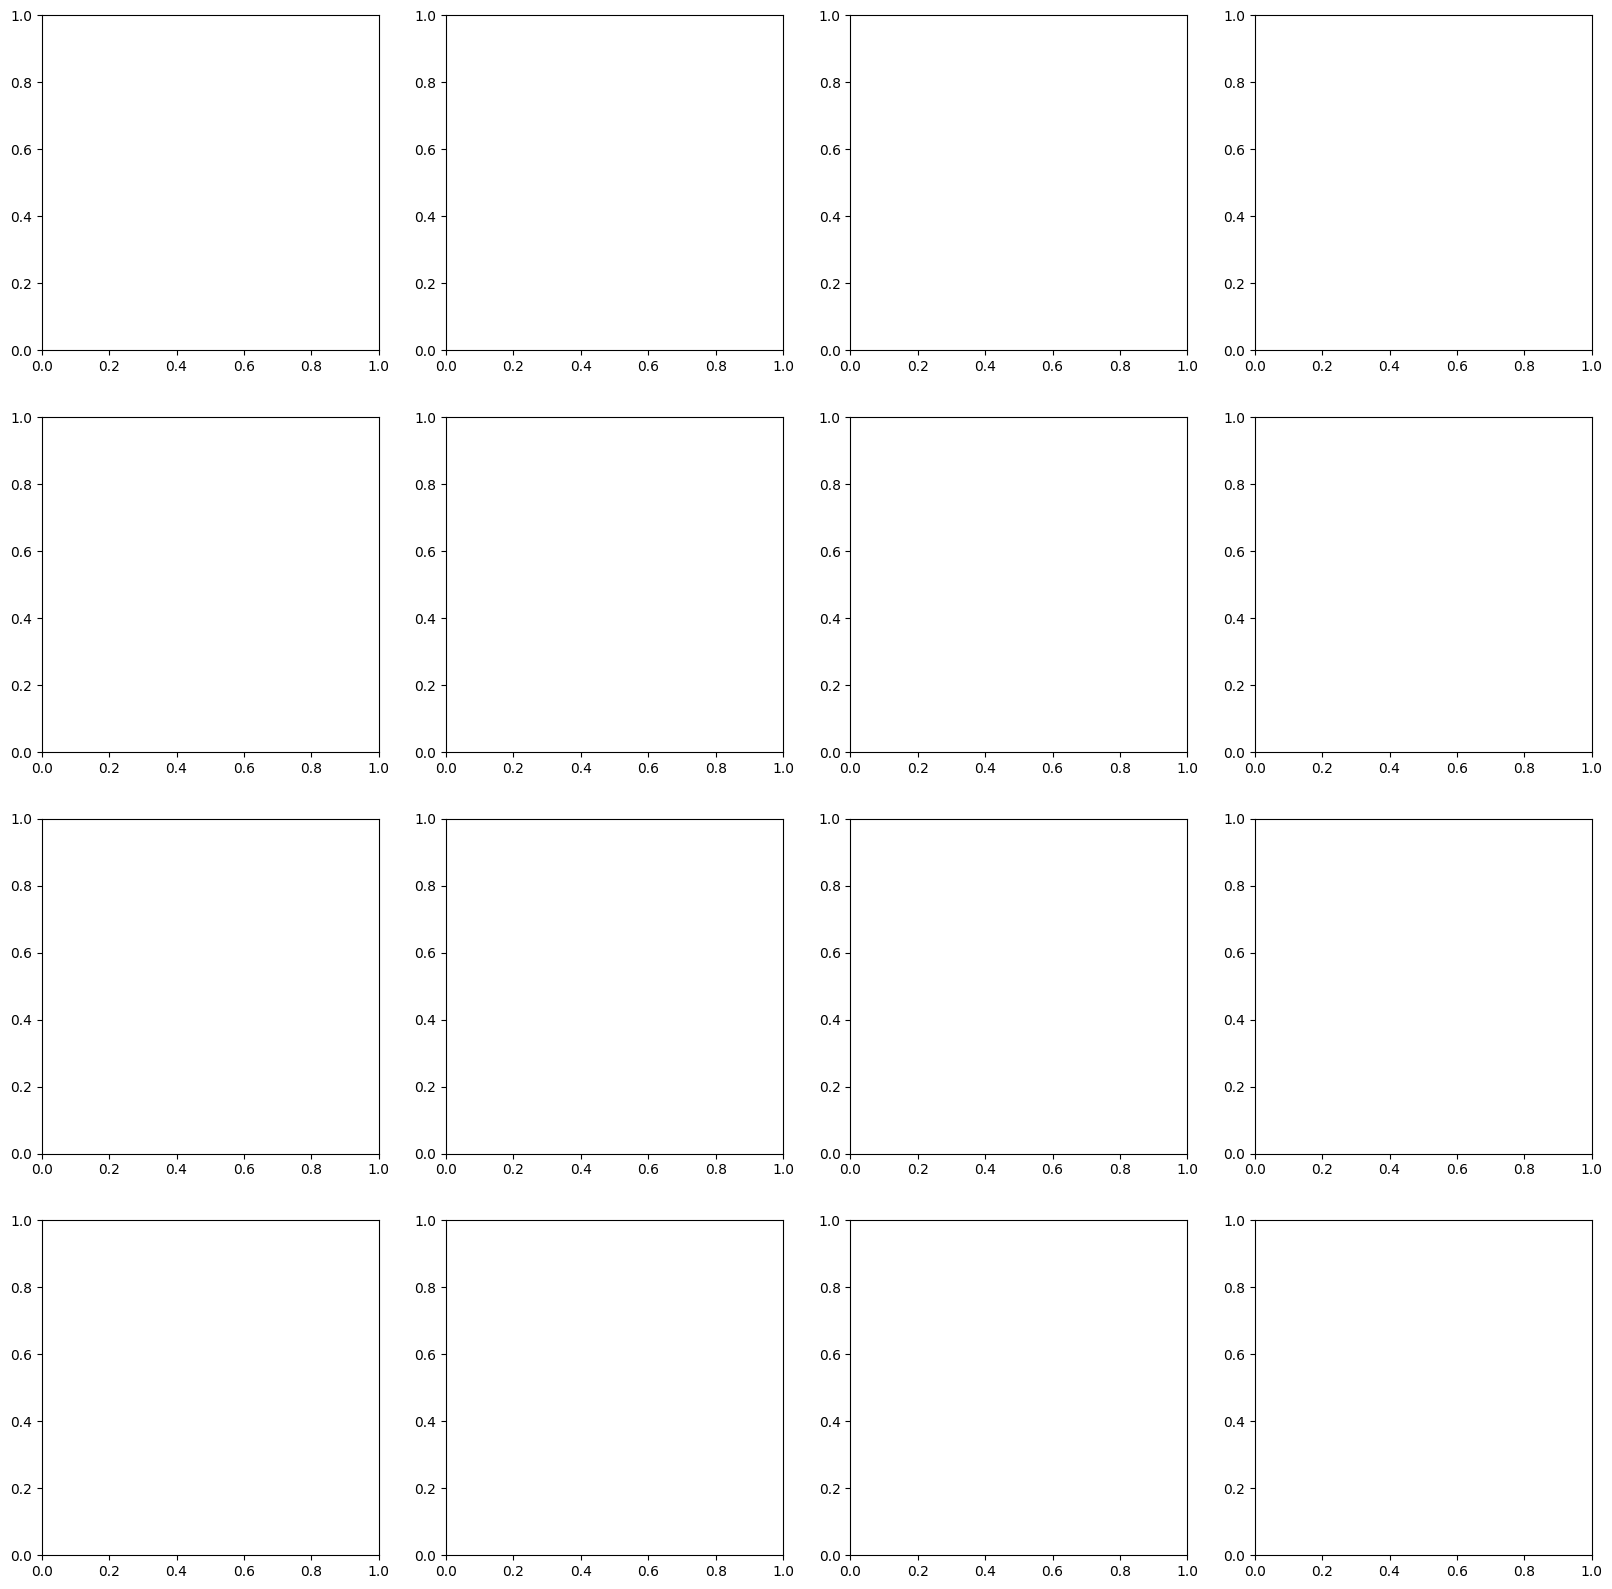

In [ ]:
# Define the grid of parameter values
param_values = np.linspace(0.5, 10, 50)

# Create a meshgrid for the parameters
param_grid1, param_grid2 = np.meshgrid(param_values, param_values)

# Create a figure with subplots
fig, axs = plt.subplots(
    len(hyperparam_rule_dict), len(hyperparam_rule_dict), figsize=(20, 20)
)

# Iterate over the hyperparam_rule_dict to create heatmaps for each combination of parameters
for a, param1 in enumerate(hyperparam_rule_dict.keys()):
    for b, param2 in enumerate(hyperparam_rule_dict.keys()):
        if param1 != param2 and a < b:
            # Create a copy of the optimal_param_list to modify
            optimal_param_list_copy = optimal_param_list.copy()

            # Calculate the log evidence for each combination of parameters
            log_evidence_grid = np.zeros_like(param_grid1)
            for i in range(param_grid1.shape[0]):
                for j in range(param_grid1.shape[1]):
                    optimal_param_list_copy[a] = param_grid1[i, j]
                    optimal_param_list_copy[b] = param_grid2[i, j]
                    log_evidence_grid[i, j] = get_total_log_evidence(
                        optimal_param_list_copy,
                        param_dict_sim_lm,
                        f_dict_sim_lm,
                        hyperparam_rule_dict,
                        analysis_times,
                        ["0001"],
                        [(2, 2)],
                    )

            # Create the heatmap
            im = axs[a, b].imshow(
                log_evidence_grid,
                extent=(
                    param_values.min(),
                    param_values.max(),
                    param_values.min(),
                    param_values.max(),
                ),
                origin="lower",
                aspect="auto",
                cmap="viridis",
            )
            axs[a, b].set_xlabel(param1)
            axs[a, b].set_ylabel(param2)
            axs[a, b].set_title(f"{param1} vs {param2}")
            fig.colorbar(im, ax=axs[a, b], label="Log Evidence")

plt.tight_layout()
plt.show()

In [ ]:
SPH_MODES_FULL = [
    (2, 2),
    (2, 1),
    (3, 3),
    (3, 2),
    (4, 4),
    (5, 2),
    (5, 5),
    # (2, -2),
    # (2, -1),
    # (3, -3),
    # (3, -2),
    # (4, -4),
]

SPH_MODES_NOPRECESS_Q1 = [(2, 2), (3, 2), (4, 4)]
SPH_MODES_NOPRECESS = [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)]
SPH_MODES_Q1 = [(2, 2), (3, 2), (4, 4), (2, -2), (3, -2), (4, -4)]

(0.0, 100.0)

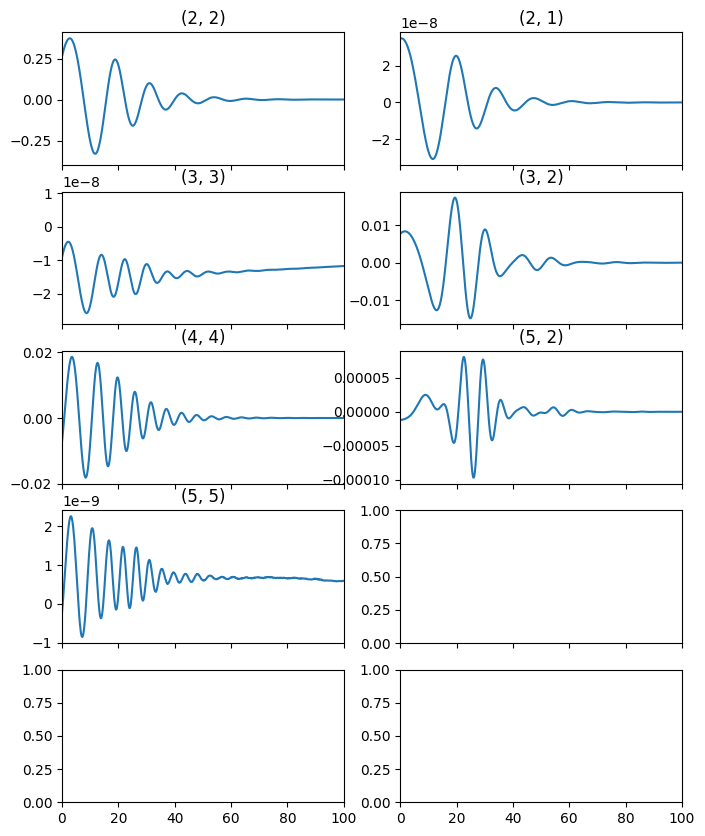

In [ ]:
sim_test = CCE.SXS_CCE("0009", lev="Lev5", radius="R2")

fig, axs = plt.subplots(5, 2, sharex=True, figsize=(8, 10))

for i, mode in enumerate(SPH_MODES_FULL):
    row = i // 2
    col = i % 2
    axs[row, col].plot(sim_test.times, sim_test.h[mode].real, label=f"{mode}")
    axs[row, col].set_title(f"{mode}")

axs[0, 0].set_xlim(0, 100)

(0.0, 100.0)

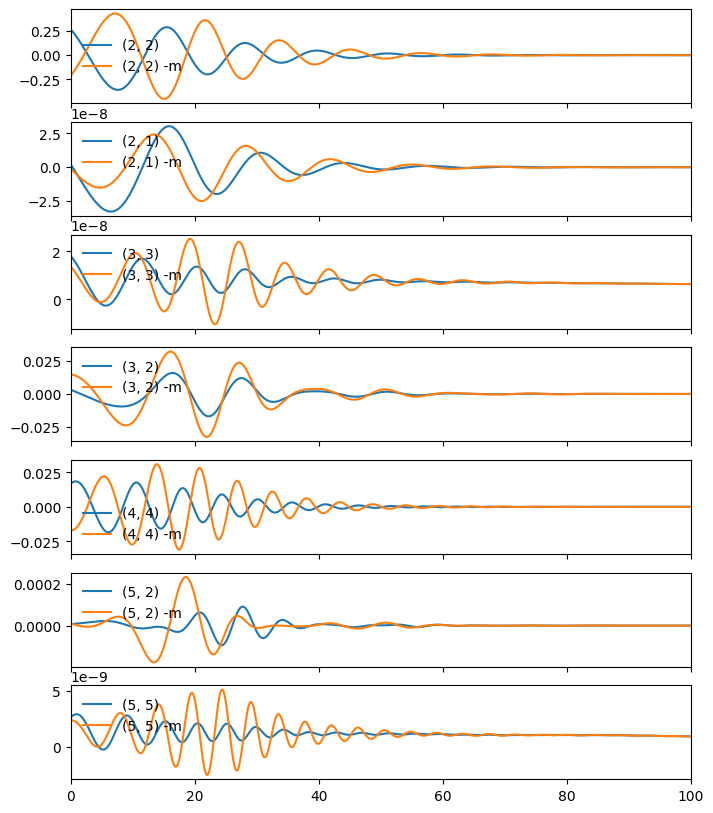

In [ ]:
sim_test = CCE.SXS_CCE("0009", lev="Lev5", radius="R2")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(8, 10))

for i, mode in enumerate(SPH_MODES_FULL):
    ell, m = mode
    axs[i].plot(sim_test.times, sim_test.h[mode].imag, label=f"{mode}")
    axs[i].plot(sim_test.times, sim_test.h[(ell, -m)].imag, label=f"{mode} -m")
    axs[i].legend(frameon=False)
axs[0].set_xlim(0, 100)